In [1]:
pip install --upgrade pip setuptools


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets


In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[]

In [6]:
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [7]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Priyanshu kumar\tensorflow_datasets\fashion_mnist\3.0.1.incomplete18K6GN\fashion_mnist-trai…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Priyanshu kumar\tensorflow_datasets\fashion_mnist\3.0.1.incomplete18K6GN\fashion_mnist-test…

Dataset fashion_mnist downloaded and prepared to C:\Users\Priyanshu kumar\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [11]:
ds.as_numpy_iterator().next()['label']

2

# Viaualize data and Build pipeline

In [12]:
# Do some data transformation
import numpy as np

In [13]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [17]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  2],
        [127],
        [106],
        [136],
        [102],
        [147],
        [136],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 64],
        [254],
        [255],
        [254],
        [255],
        [255],
        [255],
        [247],
        [161],
        [122],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 97],
        [255],
      

In [21]:
ax

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '7'}>,
       <Axes: title={'center': '5'}>, <Axes: title={'center': '4'}>],
      dtype=object)

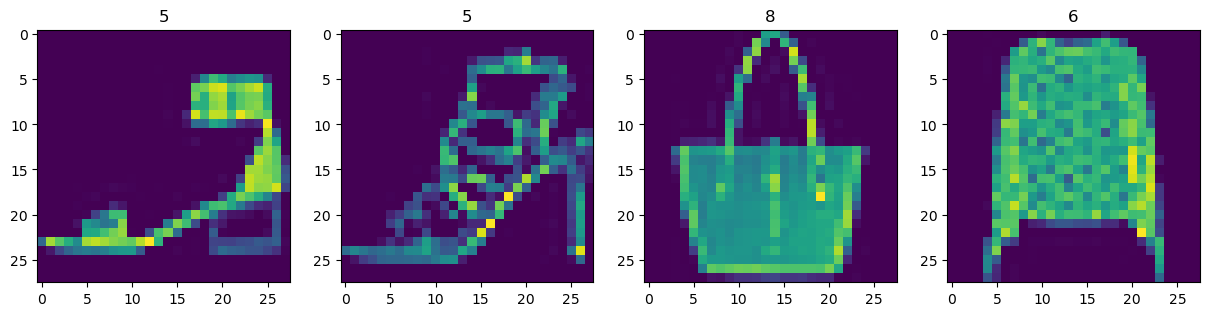

In [26]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(15,15))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [27]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [182]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [183]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Build neural network

## Import Modelling Components

In [184]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

# Build generator

In [185]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [186]:
generator = build_generator()

In [187]:
generator.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_18 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_81 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [188]:
img.shape

(4, 28, 28, 1)

In [189]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 155ms/step


In [190]:
img.shape

(4, 28, 28, 1)

In [106]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 53ms/step


In [107]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 54ms/step


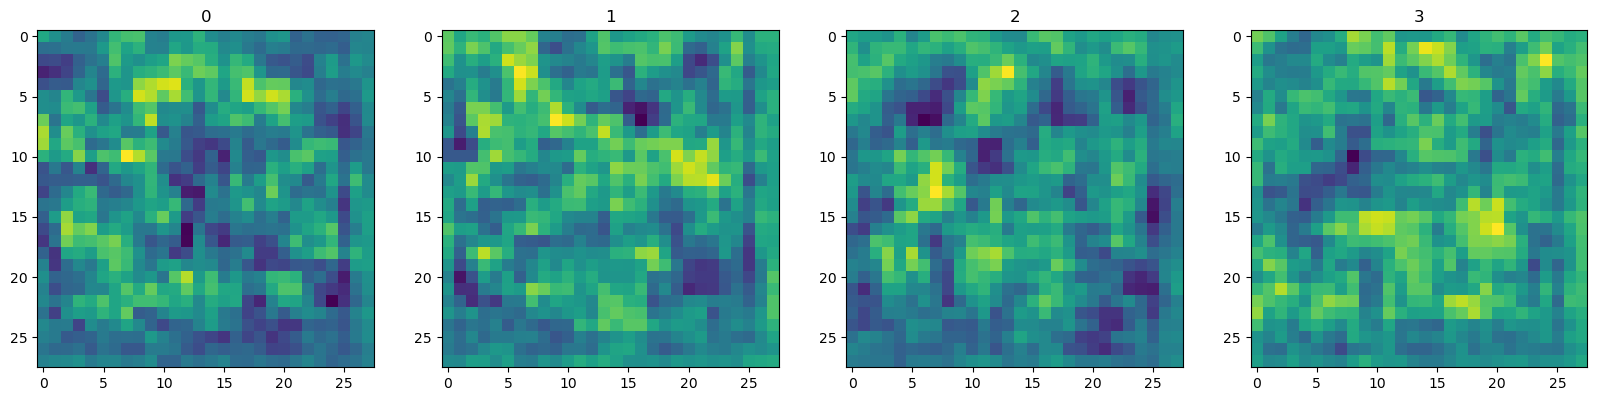

In [142]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [143]:
img.shape

(28, 28, 1)

In [165]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [191]:
img.shape

(4, 28, 28, 1)

In [192]:
discriminator = build_discriminator()

In [193]:
img.shape

(4, 28, 28, 1)

In [194]:
discriminator.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_86 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_45 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_87 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_87 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_46 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 128)     

In [199]:
img.shape

(4, 28, 28, 1)

In [201]:
discriminator.predict(img)

1/1 [==============================] - 0s 34ms/step


array([[0.5004475],
       [0.5003737],
       [0.500468 ],
       [0.5003177]], dtype=float32)

In [197]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 118ms/step


array([[0.5004475]], dtype=float32)

# Construct Training Loop

# Setup Losses and Optimizers

In [203]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [204]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# Build Subclassed Model

In [205]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [210]:
tf.zeros_like(tf.random.normal((6,128)))

<tf.Tensor: shape=(6, 128), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

In [211]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [212]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [213]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

# Build call back

In [214]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [218]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

# Train

In [219]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [222]:
import os
import multiprocessing

# Method 1: Using the os module
num_cores_os = os.cpu_count()
print(f"Number of CPU cores (using os module): {num_cores_os}")

Number of CPU cores (using os module): 8


In [ ]:
num_cores_multiprocessing = multiprocessing.cpu_count()
print(f"Number of CPU cores (using multiprocessing module): {num_cores_multiprocessing}")

In [228]:

hist = fashgan.fit(ds, epochs=5, callbacks=[ModelMonitor()])


Epoch 1/5
469/469 [==============================] - 2855s 6s/step - d_loss: 0.2773 - g_loss: 2.5987
Epoch 2/5
469/469 [==============================] - 2858s 6s/step - d_loss: 0.6149 - g_loss: 1.1193
Epoch 3/5
469/469 [==============================] - 3108s 7s/step - d_loss: 0.6902 - g_loss: 0.6295
Epoch 4/5
469/469 [==============================] - 3372s 7s/step - d_loss: 0.6471 - g_loss: 0.6134
Epoch 5/5
469/469 [==============================] - 3218s 7s/step - d_loss: 0.4410 - g_loss: 0.1152


# Review Performance

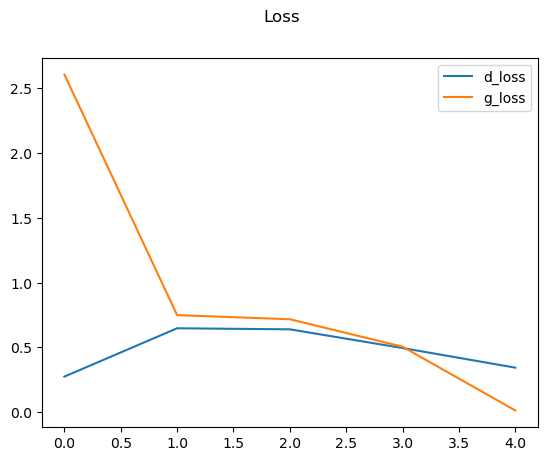

In [231]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Testing out generator

In [235]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
imgs

1/1 [==============================] - 5s 5s/step


array([[[[5.21485284e-02],
         [2.19013214e-01],
         [1.55486614e-01],
         ...,
         [3.38951600e-06],
         [9.99993145e-01],
         [1.00000000e+00]],

        [[1.05752047e-08],
         [1.80154007e-08],
         [1.01155728e-09],
         ...,
         [1.95712759e-03],
         [1.00000000e+00],
         [1.00000000e+00]],

        [[3.00612109e-23],
         [8.64338007e-26],
         [1.21671395e-26],
         ...,
         [2.10624235e-03],
         [1.00000000e+00],
         [1.00000000e+00]],

        ...,

        [[1.00000000e+00],
         [1.00000000e+00],
         [9.99491155e-01],
         ...,
         [7.44938180e-02],
         [8.62550078e-05],
         [1.62139942e-04]],

        [[1.00000000e+00],
         [1.00000000e+00],
         [9.98272896e-01],
         ...,
         [3.62005942e-02],
         [2.34418013e-03],
         [5.94371092e-03]],

        [[9.99995887e-01],
         [9.99985039e-01],
         [9.80668604e-01],
         ...,
 

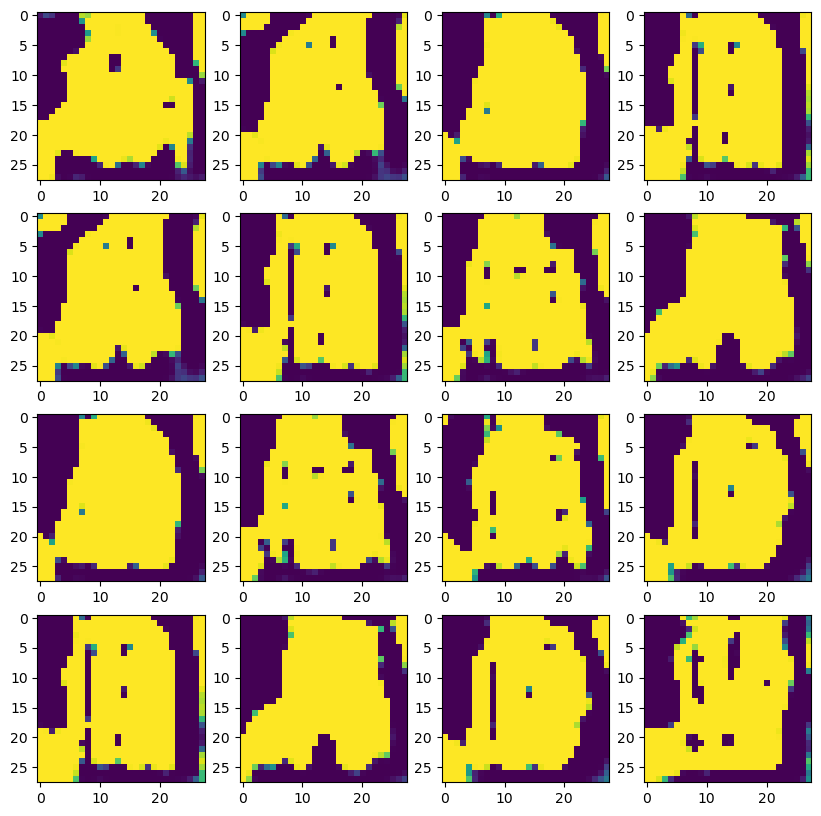

In [236]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [237]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

C:\ML\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
